<a target="_blank" href="https://colab.research.google.com/github/heechul/DeepPicar-v3/blob/devel/RunAll.ipynb">
        <img src="https://i.ibb.co/2P3SLwK/colab.png"  style="padding-bottom:5px;" />Run in Google Colab</a>

In [272]:
import tensorflow as tf

import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.utils import class_weight
# from skimage import data
from skimage import io
print(tf.__version__)

from keras import layers
import rosbag

import os
import time
import math
import random

2.14.0


In [273]:
use_finetuning = False


In [274]:

bagfiles = ['Dataset/f2.bag', 'Dataset/f4.bag', 'Dataset/qualifier_out.bag']

lidar = []
servo = []
speed = []
for bagfile in bagfiles:
    bag = rosbag.Bag(bagfile)
    for topic, msg, t in bag.read_messages():
        if topic =='Lidar':
            lidar.append(msg.ranges)
            # lidar.append(np.array(msg.ranges).reshape(1,1081))
        if topic =='Ackermann':
            servo.append(msg.drive.steering_angle)
            speed.append(msg.drive.speed)
    bag.close()



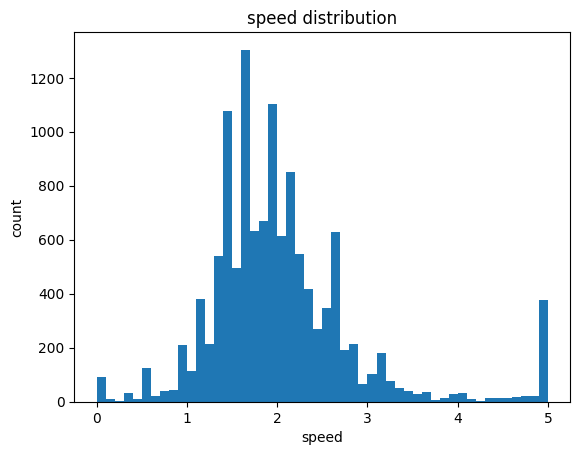

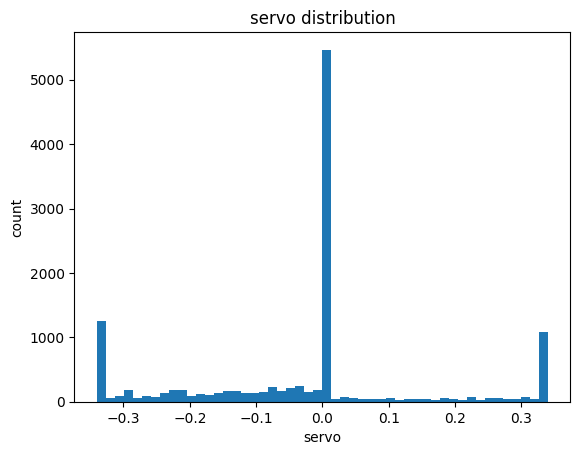

In [275]:
# visualize speed distribution
plt.hist(speed, bins=50)
plt.xlabel('speed')
plt.ylabel('count')
plt.title('speed distribution')
plt.show()

# visualize servo distribution
plt.hist(servo, bins=50)
plt.xlabel('servo')
plt.ylabel('count')
plt.title('servo distribution')
plt.show()



In [276]:
# preprocess the data
lidar_2d = np.asarray(lidar).reshape(-1,1,1081,1)
servo = np.asarray(servo)
speed = np.asarray(speed) 

# normalize the speed between 0 to 1 
speed = (speed - min(speed))/(max(speed)-min(speed))

print (lidar_2d.shape)

(12329, 1, 1081, 1)


In [277]:
# Split Dataset
print('Spliting Data to Train/Test')

test_data = np.concatenate((servo[:, np.newaxis], speed[:, np.newaxis]), axis=1)
print(f'Test Data {test_data.shape}')

x_train, x_test, y_train, y_test = train_test_split(lidar_2d, test_data, test_size = 0.35)
#x_train, x_test, y_train, y_test = train_test_split(lidar, servo, test_size = 0.35)
print(f'Train Size: {len(x_train)}')
print(f'Test Size: {len(x_test)}')
print(f'y_test.shape{y_test.shape}')

Spliting Data to Train/Test
Test Data (12329, 2)
Train Size: 8013
Test Size: 4316
y_test.shape(4316, 2)


In [278]:
model = tf.keras.Sequential()

img_width = 1081
img_height = 1
img_channels = 1
temporal_context = 1

l1_stride = 4
l2_stride = 4
l3_stride = 2
l1_kernel = (1,10)
l2_kernel = (1,8)
l3_kernel = (1,4)
l4_kernel = (1,3)
l5_kernel = (1,3)


model.add(layers.Conv2D(24, l1_kernel, strides=(l1_stride, l1_stride), activation='relu', input_shape=(img_height,img_width,img_channels*temporal_context)))
model.add(layers.Conv2D(36, l2_kernel, strides=(l2_stride, l2_stride), activation='relu'))
model.add(layers.Conv2D(48, l3_kernel, strides=(l3_stride, l3_stride), activation='relu'))
model.add(layers.Conv2D(64, l4_kernel, activation='relu'))
model.add(layers.Conv2D(64, l5_kernel, activation='relu'))
model.add(layers.Flatten())

model.add(layers.Dropout(0.3))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2, name="output", activation='tanh'))

model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 1, 268, 24)        264       
                                                                 
 conv2d_61 (Conv2D)          (None, 1, 66, 36)         6948      
                                                                 
 conv2d_62 (Conv2D)          (None, 1, 32, 48)         6960      
                                                                 
 conv2d_63 (Conv2D)          (None, 1, 30, 64)         9280      
                                                                 
 conv2d_64 (Conv2D)          (None, 1, 28, 64)         12352     
                                                                 
 flatten_18 (Flatten)        (None, 1792)              0         
                                                                 
 dropout_72 (Dropout)        (None, 1792)            

In [279]:
# a function to calculate MACs and FLOPs of the model
def calc_MAC_FLOPs(model):
    MACs = 0
    FLOPs = 0
    print ("layer name, output shape, MACs, FLOPs")
    for layer in model.layers:
        if isinstance(layer, layers.Conv1D):
            _, Wo, Co = layer.output_shape # batch, width, channels
            Kw, Ci, _ = layer.kernel.shape # kernel width, input channels, output channels
            mac = Wo * Co * Kw * Ci
            flop = 2 * mac
        elif isinstance(layer, layers.Conv2D):
            _, Ho, Wo, Co = layer.output_shape # batch, height, width, channels
            Kh, Kw, Ci, _ = layer.kernel.shape # kernel height, kernel width, input channels, output channels
            mac = Ho * Wo * Co * Kh * Kw * Ci
            flop = 2 * mac
        elif isinstance(layer, layers.Dense):
            _, Co = layer.output_shape # batch, output channels
            Ci, _ = layer.kernel.shape # input channels, output channels
            mac = Ci * Co
            flop = 2 * mac
        elif isinstance(layer, layers.Flatten):
            mac = 0
            flop = 0
        elif isinstance(layer, layers.Dropout):
            # skip dropout layer
            continue
        else:
            raise Exception("unknown layer type")
        MACs += mac
        FLOPs += flop
        print(layer.name, layer.output_shape, mac, flop)

    return MACs, FLOPs

macs, _ = calc_MAC_FLOPs(model)
print("MACs: ", macs)

layer name, output shape, MACs, FLOPs
conv2d_60 (None, 1, 268, 24) 64320 128640
conv2d_61 (None, 1, 66, 36) 456192 912384
conv2d_62 (None, 1, 32, 48) 221184 442368
conv2d_63 (None, 1, 30, 64) 276480 552960
conv2d_64 (None, 1, 28, 64) 344064 688128
flatten_18 (None, 1792) 0 0
dense_54 (None, 100) 179200 358400
dense_55 (None, 50) 5000 10000
dense_56 (None, 10) 500 1000
output (None, 2) 20 40
MACs:  1546960


In [280]:
lr = 3e-4
batch_size = 128
num_epochs = 100
loss_fn = 'huber'

optimizer = tf.keras.optimizers.legacy.Adam(lr)
model.compile(optimizer=optimizer, loss=loss_fn)

print (x_train.shape, y_train.shape, x_test.shape, y_test.shape)

start_time = time.time()
history = model.fit(x_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(x_test, y_test))



(8013, 1, 1081, 1) (8013, 2) (4316, 1, 1081, 1) (4316, 2)
Epoch 1/100
63/63 [==============================] - 2s 19ms/step - loss: 0.0224 - val_loss: 0.0113
Epoch 2/100
63/63 [==============================] - 1s 14ms/step - loss: 0.0159 - val_loss: 0.0101
Epoch 3/100
63/63 [==============================] - 1s 14ms/step - loss: 0.0140 - val_loss: 0.0092
Epoch 4/100
63/63 [==============================] - 1s 14ms/step - loss: 0.0130 - val_loss: 0.0083
Epoch 5/100
63/63 [==============================] - 1s 14ms/step - loss: 0.0124 - val_loss: 0.0080
Epoch 6/100
63/63 [==============================] - 1s 14ms/step - loss: 0.0114 - val_loss: 0.0077
Epoch 7/100
63/63 [==============================] - 1s 14ms/step - loss: 0.0111 - val_loss: 0.0074
Epoch 8/100
63/63 [==============================] - 1s 15ms/step - loss: 0.0106 - val_loss: 0.0081
Epoch 9/100
63/63 [==============================] - 1s 14ms/step - loss: 0.0104 - val_loss: 0.0073
Epoch 10/100
63/63 [======================

Training took 98.00520586967468 seconds


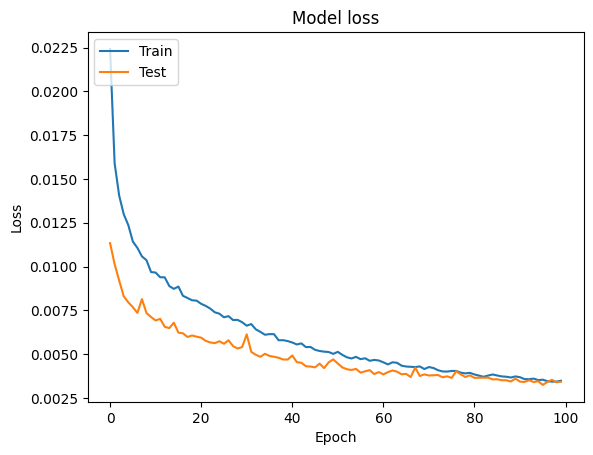

In [281]:
print(f"Training took {time.time() - start_time} seconds")
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [282]:
#======================================================
# Model Evaluation
test_loss = model.evaluate(x_test, y_test)
print(f'test_loss = {test_loss}')

y_pred = model.predict(x_test)
print(f'y_pred.shape: {y_pred.shape}')
accuracy = np.mean(y_pred == y_test)
r2 = r2_score(y_test, y_pred)
error = mean_squared_error(y_test, y_pred)
print(f'Accuracy: {accuracy:.3f}')
print(f'r2: {r2:.3f}')
print(f'Error: {error}')


135/135 [==============================] - 0s 3ms/step - loss: 0.0034
test_loss = 0.003422008128836751
135/135 [==============================] - 0s 2ms/step
y_pred.shape: (4316, 2)
Accuracy: 0.000
r2: 0.778
Error: 0.006844014800736448


In [283]:
# Save Model
model_file = 'tinylidarnet_1081_conv2d'
model.save(model_file+'.h5')
print("Model Saved")

converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]

quantized_tflite_model = converter.convert()

with open(model_file+".tflite", 'wb') as f:
    f.write(quantized_tflite_model)
    print (model_file+".tflite is saved. copy this file to the robot")
print('Tf_lite Model also saved')


Model Saved


/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /var/folders/2_/kskwshj16hqb0586p6cydg4h0000gq/T/tmp549l5zu9/assets


INFO:tensorflow:Assets written to: /var/folders/2_/kskwshj16hqb0586p6cydg4h0000gq/T/tmp549l5zu9/assets


tinylidarnet_1081_conv2d.tflite is saved. copy this file to the robot
Tf_lite Model also saved


2024-03-14 11:47:56.746457: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-03-14 11:47:56.746835: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-03-14 11:47:56.747718: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/2_/kskwshj16hqb0586p6cydg4h0000gq/T/tmp549l5zu9
2024-03-14 11:47:56.749240: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-03-14 11:47:56.749245: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/2_/kskwshj16hqb0586p6cydg4h0000gq/T/tmp549l5zu9
2024-03-14 11:47:56.756680: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-03-14 11:47:56.832228: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /var/folders/2_/kskwshj16hqb0586p6cydg4h0000gq/T/tmp549l5zu9
2024-03-

In [284]:
print("Quantize Model")
import tensorflow_model_optimization as tfmot

quantize_model = tfmot.quantization.keras.quantize_model
q_aware_model = quantize_model(model)

print ("Model compile")
q_aware_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(lr), loss=loss_fn)  # loss='mse'
q_aware_model.summary()

Quantize Model
Model compile
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer_10 (Quantiz  (None, 1, 1081, 1)        3         
 eLayer)                                                         
                                                                 
 quant_conv2d_60 (QuantizeW  (None, 1, 268, 24)        315       
 rapperV2)                                                       
                                                                 
 quant_conv2d_61 (QuantizeW  (None, 1, 66, 36)         7023      
 rapperV2)                                                       
                                                                 
 quant_conv2d_62 (QuantizeW  (None, 1, 32, 48)         7059      
 rapperV2)                                                       
                                                                 
 quant_conv2d_63 (Quanti

Model fit
Epoch 1/30
63/63 [==============================] - 3s 25ms/step - loss: 0.0044 - val_loss: 0.0041
Epoch 2/30
63/63 [==============================] - 1s 21ms/step - loss: 0.0041 - val_loss: 0.0041
Epoch 3/30
63/63 [==============================] - 1s 22ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 4/30
63/63 [==============================] - 1s 23ms/step - loss: 0.0041 - val_loss: 0.0038
Epoch 5/30
63/63 [==============================] - 1s 22ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 6/30
63/63 [==============================] - 1s 22ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 7/30
63/63 [==============================] - 2s 25ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 8/30
63/63 [==============================] - 1s 22ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 9/30
63/63 [==============================] - 1s 22ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 10/30
63/63 [==============================] - 1s 22ms/step - loss: 0.0036 - val_loss: 0.0036

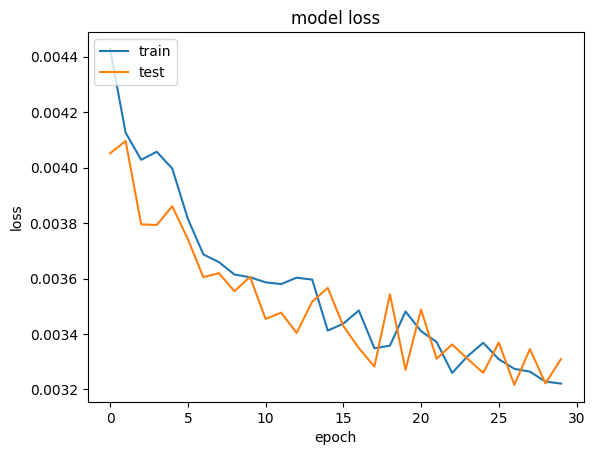

In [285]:
# class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
# class_weights = {i:class_weights[i] for i in range(len(class_weights))}
# print("class_weights", class_weights)

if use_finetuning:
    q_aware_model.load_weights(model_file + ".h5")
    print("loaded weights from", model_file + ".h5")
    num_epochs = 5
else:
    num_epochs = 30

# Continue with the rest of the code
print ("Model fit")
# q_aware_model.reset_states()
history = q_aware_model.fit(x_train, y_train, batch_size=batch_size,
                    epochs=num_epochs, validation_data=(x_test, y_test))

# Plot training and validation losses 
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show() 

In [286]:
# Model Evaluation

test_loss = q_aware_model.evaluate(x_test, y_test)
print(f'test_loss = {test_loss}')

y_pred = q_aware_model.predict(x_test)
print(f'y_pred.shape: {y_pred.shape}')
accuracy = np.mean(y_pred == y_test)
r2 = r2_score(y_test, y_pred)
error = mean_squared_error(y_test, y_pred)
print(f'Accuracy: {accuracy:.3f}')
print(f'r2: {r2:.3f}')
print(f'Error: {error}')

  1/135 [..............................] - ETA: 4s - loss: 0.0030

135/135 [==============================] - 1s 4ms/step - loss: 0.0033
test_loss = 0.003309371182695031
135/135 [==============================] - 1s 4ms/step
y_pred.shape: (4316, 2)
Accuracy: 0.085
r2: 0.784
Error: 0.006618743088480107


visualization

generate image cpp files for testing

In [287]:
# Save both the Keras and TFLite models      
print("Model Save")             

model_file = 'tinylidarnet_1081_conv2d_quantized'     
q_aware_model.save(model_file+".h5")

print("TFLite Model")
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.inference_input_type = tf.int8
# converter.inference_output_type = tf.int8

print("Using int8 quantization")

quantized_tflite_model = converter.convert()

with open(model_file+".tflite", 'wb') as f:
    f.write(quantized_tflite_model)

print (model_file+".tflite is saved. copy this file to the robot")


Model Save
TFLite Model
Using int8 quantization


/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /var/folders/2_/kskwshj16hqb0586p6cydg4h0000gq/T/tmpcnj4ouej/assets


INFO:tensorflow:Assets written to: /var/folders/2_/kskwshj16hqb0586p6cydg4h0000gq/T/tmpcnj4ouej/assets
/opt/homebrew/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:947: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


tinylidarnet_1081_conv2d_quantized.tflite is saved. copy this file to the robot


2024-03-14 11:48:53.326519: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-03-14 11:48:53.326928: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-03-14 11:48:53.327891: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/2_/kskwshj16hqb0586p6cydg4h0000gq/T/tmpcnj4ouej
2024-03-14 11:48:53.332374: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-03-14 11:48:53.332388: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/2_/kskwshj16hqb0586p6cydg4h0000gq/T/tmpcnj4ouej
2024-03-14 11:48:53.346734: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-03-14 11:48:53.490912: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /var/folders/2_/kskwshj16hqb0586p6cydg4h0000gq/T/tmpcnj4ouej
2024-03-

generate cc file from tflite model

In [288]:
!xxd -n gmodel -i {model_file}.tflite > {model_file}.cc
print ("models/"+model_file+".cc --> src/model.h")
!cat {model_file}.cc | sed "s/unsigned/const unsigned/g" > src/model.h

models/tinylidarnet_1081_conv2d_quantized.cc --> src/model.h


In [289]:
idx=100
img = x_test[idx]
# Write a C source file of the image for debugging purposes (to check if the model output is correct)
with open('src/img.h', 'w') as f:
    f.write('#ifndef IMG_TEST_DATA\n')
    f.write('#define IMG_TEST_DATA\n')
    f.write('const signed char img_data[] = {')
    for i in range(0, len(img.flatten())):
        f.write(str(img.flatten()[i]))
        if i < len(img.flatten()) - 1:
            f.write(',')    
    f.write('};\n')
    f.write('#endif\n')

print(y_pred[idx])
print("Predicted: {})".format(y_pred[idx]))
print("Actual: {}".format(y_test[idx]))

[0.         0.99627185]
Predicted: [0.         0.99627185])
Actual: [0. 1.]


### Inference

In [290]:
print("test img idx: {}, shape: {}".format(idx, img.shape))
print(img.flatten())

interpreter = tf.lite.Interpreter(model_content=quantized_tflite_model)
interpreter.allocate_tensors()
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]
interpreter.set_tensor(input_index, np.expand_dims(img, axis=0).astype(np.float32))

input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

interpreter.invoke()
o_steer = interpreter.get_tensor(output_index)[0][0]
o_speed = interpreter.get_tensor(output_index)[0][1]
print("Predicted: {} {})".format(o_steer, o_speed))

test img idx: 100, shape: (1, 1081, 1)
[1.81900001 1.80900002 1.79900002 ... 0.93400002 0.93599999 0.92900002]
input:  <class 'numpy.float32'>
output:  <class 'numpy.float32'>
Predicted: 0.0 0.9921875)
